In [8]:
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from src.data_loader import create_tiledataloader_split
from src.model.mae import MAEUNetPretrain
from torchsummary import summary

def get_device():
    """
    Automatically selects the best available device (GPU if available, otherwise CPU).
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device


device = get_device()

### Load data tiles

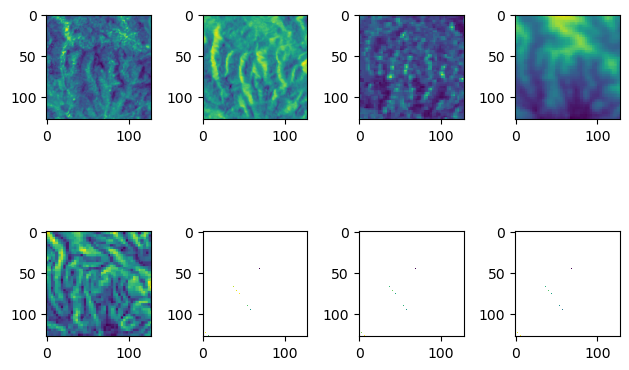

In [5]:
x = np.load("data/processed/X_tile_101.npy")
y = np.load("data/processed/y_tile_101.npy")
x_s2, x_s1, x_dem = x[0:12], x[12:18], x[18:]
fig, ax = plt.subplots(2, 4)

ax[0][0].imshow(x_s2[7]) #  NIR
ax[0][1].imshow(x_s1[1]) #  vh
ax[0][2].imshow(x_s1[4]) #  HH
ax[0][3].imshow(x_dem[0]) #  DEM

ax[1][0].imshow(x_dem[1]) #  slope
ax[1][1].imshow(y[0], interpolation="nearest") #  CC
ax[1][2].imshow(y[1], interpolation="nearest") #  FHD
ax[1][3].imshow(y[2], interpolation="nearest") #  RH95

plt.tight_layout()

In [6]:
files = glob("data/processed/y*.npy")
train_paths, val_paths = train_test_split(
    files, test_size=0.2, shuffle=True, random_state=1
)
val_paths, test_paths = train_test_split(
    val_paths, test_size=0.5, shuffle=True, random_state=1
)

In [7]:
scaling_file = "experiments/weights/scaler.pickle"
with open(scaling_file, "rb") as handle:
    means, stds, mean_y, std_y = pickle.load(handle)
# 
batch_size = 1
train_loader = create_tiledataloader_split(
    train_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=True,
)
val_loader = create_tiledataloader_split(
    val_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=True,
)
test_loader = create_tiledataloader_split(
    test_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=True,
)

for x_s2, x_s1, x_dem, y in val_loader:
    print(np.nanstd(x_s2.numpy(), axis=(0, 2, 3)))
    print(np.nanmean(y.numpy(), axis=(0, 2, 3)))
    break

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


[0.8364537  1.0696661  0.99269634 1.0076634  0.85018206 0.5310411
 0.50638497 0.5579077  0.5170852  0.43691134 0.8116778  0.94134593]
[ 0.01621211 -0.34523454 -0.2859483 ]


In [10]:
model = MAEUNetPretrain(
    in_channels=12,
    dimensions=2,
    out_channels_first_layer=16,
    conv_num_in_layer=[2, 2, 2, 2],
    kernel_size=5,
    normalization="Batch",
    downsampling_type="max",
    residual=True,
    padding_mode="zeros",
    activation="LeakyReLU",
    upsampling_type="conv",
    use_bias=True,
    use_sigmoid=False,
    lr=1e-3,
    lr_decay=0.1,
    weight_decay=1e-4,
    patch_size=128,
    mask_ratio=0.75,
    mask_channels=True,
    sensor_train="s2",
)
model = model.to(device)
summary(model, (12, 128, 128))
output = model(x_s2)
print(output[0].shape)

: 

: 